<a href="https://colab.research.google.com/github/BogdanTurbal/image_super_resolution_CSCHack_2023/blob/main/competition_csc_task_3_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def process_image(img_file, hr_shape):
    img = tf.io.read_file(img_file)
    img = tf.image.decode_jpeg(img, channels=3)

    # Normalizing the images
    img = tf.cast(img, tf.float32) / 255.0
    #img = (img - 0.5) / 0.5

    # Resizing the images
    hr_image = tf.image.resize(img, hr_shape, method=tf.image.ResizeMethod.BICUBIC)
    lr_image = tf.image.resize(img, (hr_shape[0]//8, hr_shape[1]//8), method=tf.image.ResizeMethod.BICUBIC)

    return (lr_image, hr_image)

def load_image_dataset(file_paths, hr_shape):
    # List files
    files_ds = tf.data.Dataset.list_files(file_paths, shuffle=False)

    # Use map to load images in parallel
    image_dataset = files_ds.map(lambda x: process_image(x, hr_shape), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return image_dataset

# Example usage:
#train_paths = [f for f in os.listdir('/kaggle/input/human-faces/Humans') if f.endswith('.jpg')]
hr_shape = (256, 256)

In [ ]:
import os
import glob
from multiprocessing import Pool

def get_images_from_extension(params):
    directory, extension = params
    return glob.glob(f"{directory}/**/*.{extension}", recursive=True)

def get_all_images(directory, extensions=['jpg', 'jpeg', 'png']):
    with Pool(os.cpu_count()) as p:
        files = p.map(get_images_from_extension, [(directory, ext) for ext in extensions])
    return [item for sublist in files for item in sublist]  # flatten list of lists



In [ ]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    def predict_step(self, x):
        super_resolution_img = self(x, training=False)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 1.0)
        return super_resolution_img

def Upsampling(inputs, big=False, **kwargs):
    x = layers.Conv2D(64 * 4, 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=2)
    if big:
        x = layers.Conv2D(64 * 4, 3, padding="same", **kwargs)(x)
        x = tf.nn.depth_to_space(x, block_size=2)
    return x


def ResBlock(inputs, num_filters=64):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block


def make_model(num_filters, num_of_residual_blocks, big=False):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    #x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new, num_filters=num_filters)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x, big=big)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = x#tf.keras.activations.tanh(x)#layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)

In [ ]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=1.0)[0]
    return psnr_value

In [ ]:
class CombinedModel(tf.keras.Model):
    def __init__(self, model1, model2, **kwargs):
        super(CombinedModel, self).__init__(**kwargs)
        self.model1 = model1
        self.model2 = model2

    def call(self, inputs, training=False):
        x = self.model1(inputs, training=training)
        return self.model2(x, training=training)

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dict mapping metric names to current value.
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        x = data
        super_resolution_img = self(x, training=False)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 1.0)
        return super_resolution_img


In [ ]:

optim_edsr = keras.optimizers.Adam(
learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5000], values=[1e-4, 5e-5],
))

combined_model = CombinedModel(model_S, model)
combined_model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
_ = combined_model(tf.zeros((1, 32, 32, 3)))
combined_model.load_weights('/kaggle/input/weights-1/comb_model_v_1_0.h5')

# Training for more epochs will improve results

In [ ]:
combined_model.summary()

Model: "combined_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 edsr_model_2 (EDSRModel)    (None, None, None, 3)     20071619  
                                                                 
 edsr_model_3 (EDSRModel)    (None, None, None, 3)     10041155  
                                                                 
Total params: 30,112,774
Trainable params: 30,112,774
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os
import glob
from multiprocessing import Pool

def get_images_from_extension(params):
    directory, extension = params
    return glob.glob(f"{directory}/**/*.{extension}", recursive=True)

def get_all_images(directory, extensions=['jpg', 'jpeg', 'png']):
    with Pool(os.cpu_count()) as p:
        files = p.map(get_images_from_extension, [(directory, ext) for ext in extensions])
    return [item for sublist in files for item in sublist]  # flatten list of lists

all_images = (get_all_images('/kaggle/input/human-faces', extensions=['jpg', 'jpeg', 'png'])
              + get_all_images('/kaggle/input/imdb-wiki-faces-dataset', extensions=['jpg']))

In [ ]:
all_images = sorted(all_images)

In [ ]:
batch_size = 16 #* strategy.num_replicas_in_sync
train_paths, test_paths = train_test_split(all_images, test_size=0.02, random_state=42)
total = int(len(train_paths) / batch_size)
train_dataset = load_image_dataset(train_paths, hr_shape)
test_dataset = load_image_dataset(test_paths, hr_shape)

train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size, drop_remainder=True).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=100).batch(batch_size, drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

In [ ]:
batch = next(iter(test_dataset))

<Figure size 640x480 with 0 Axes>

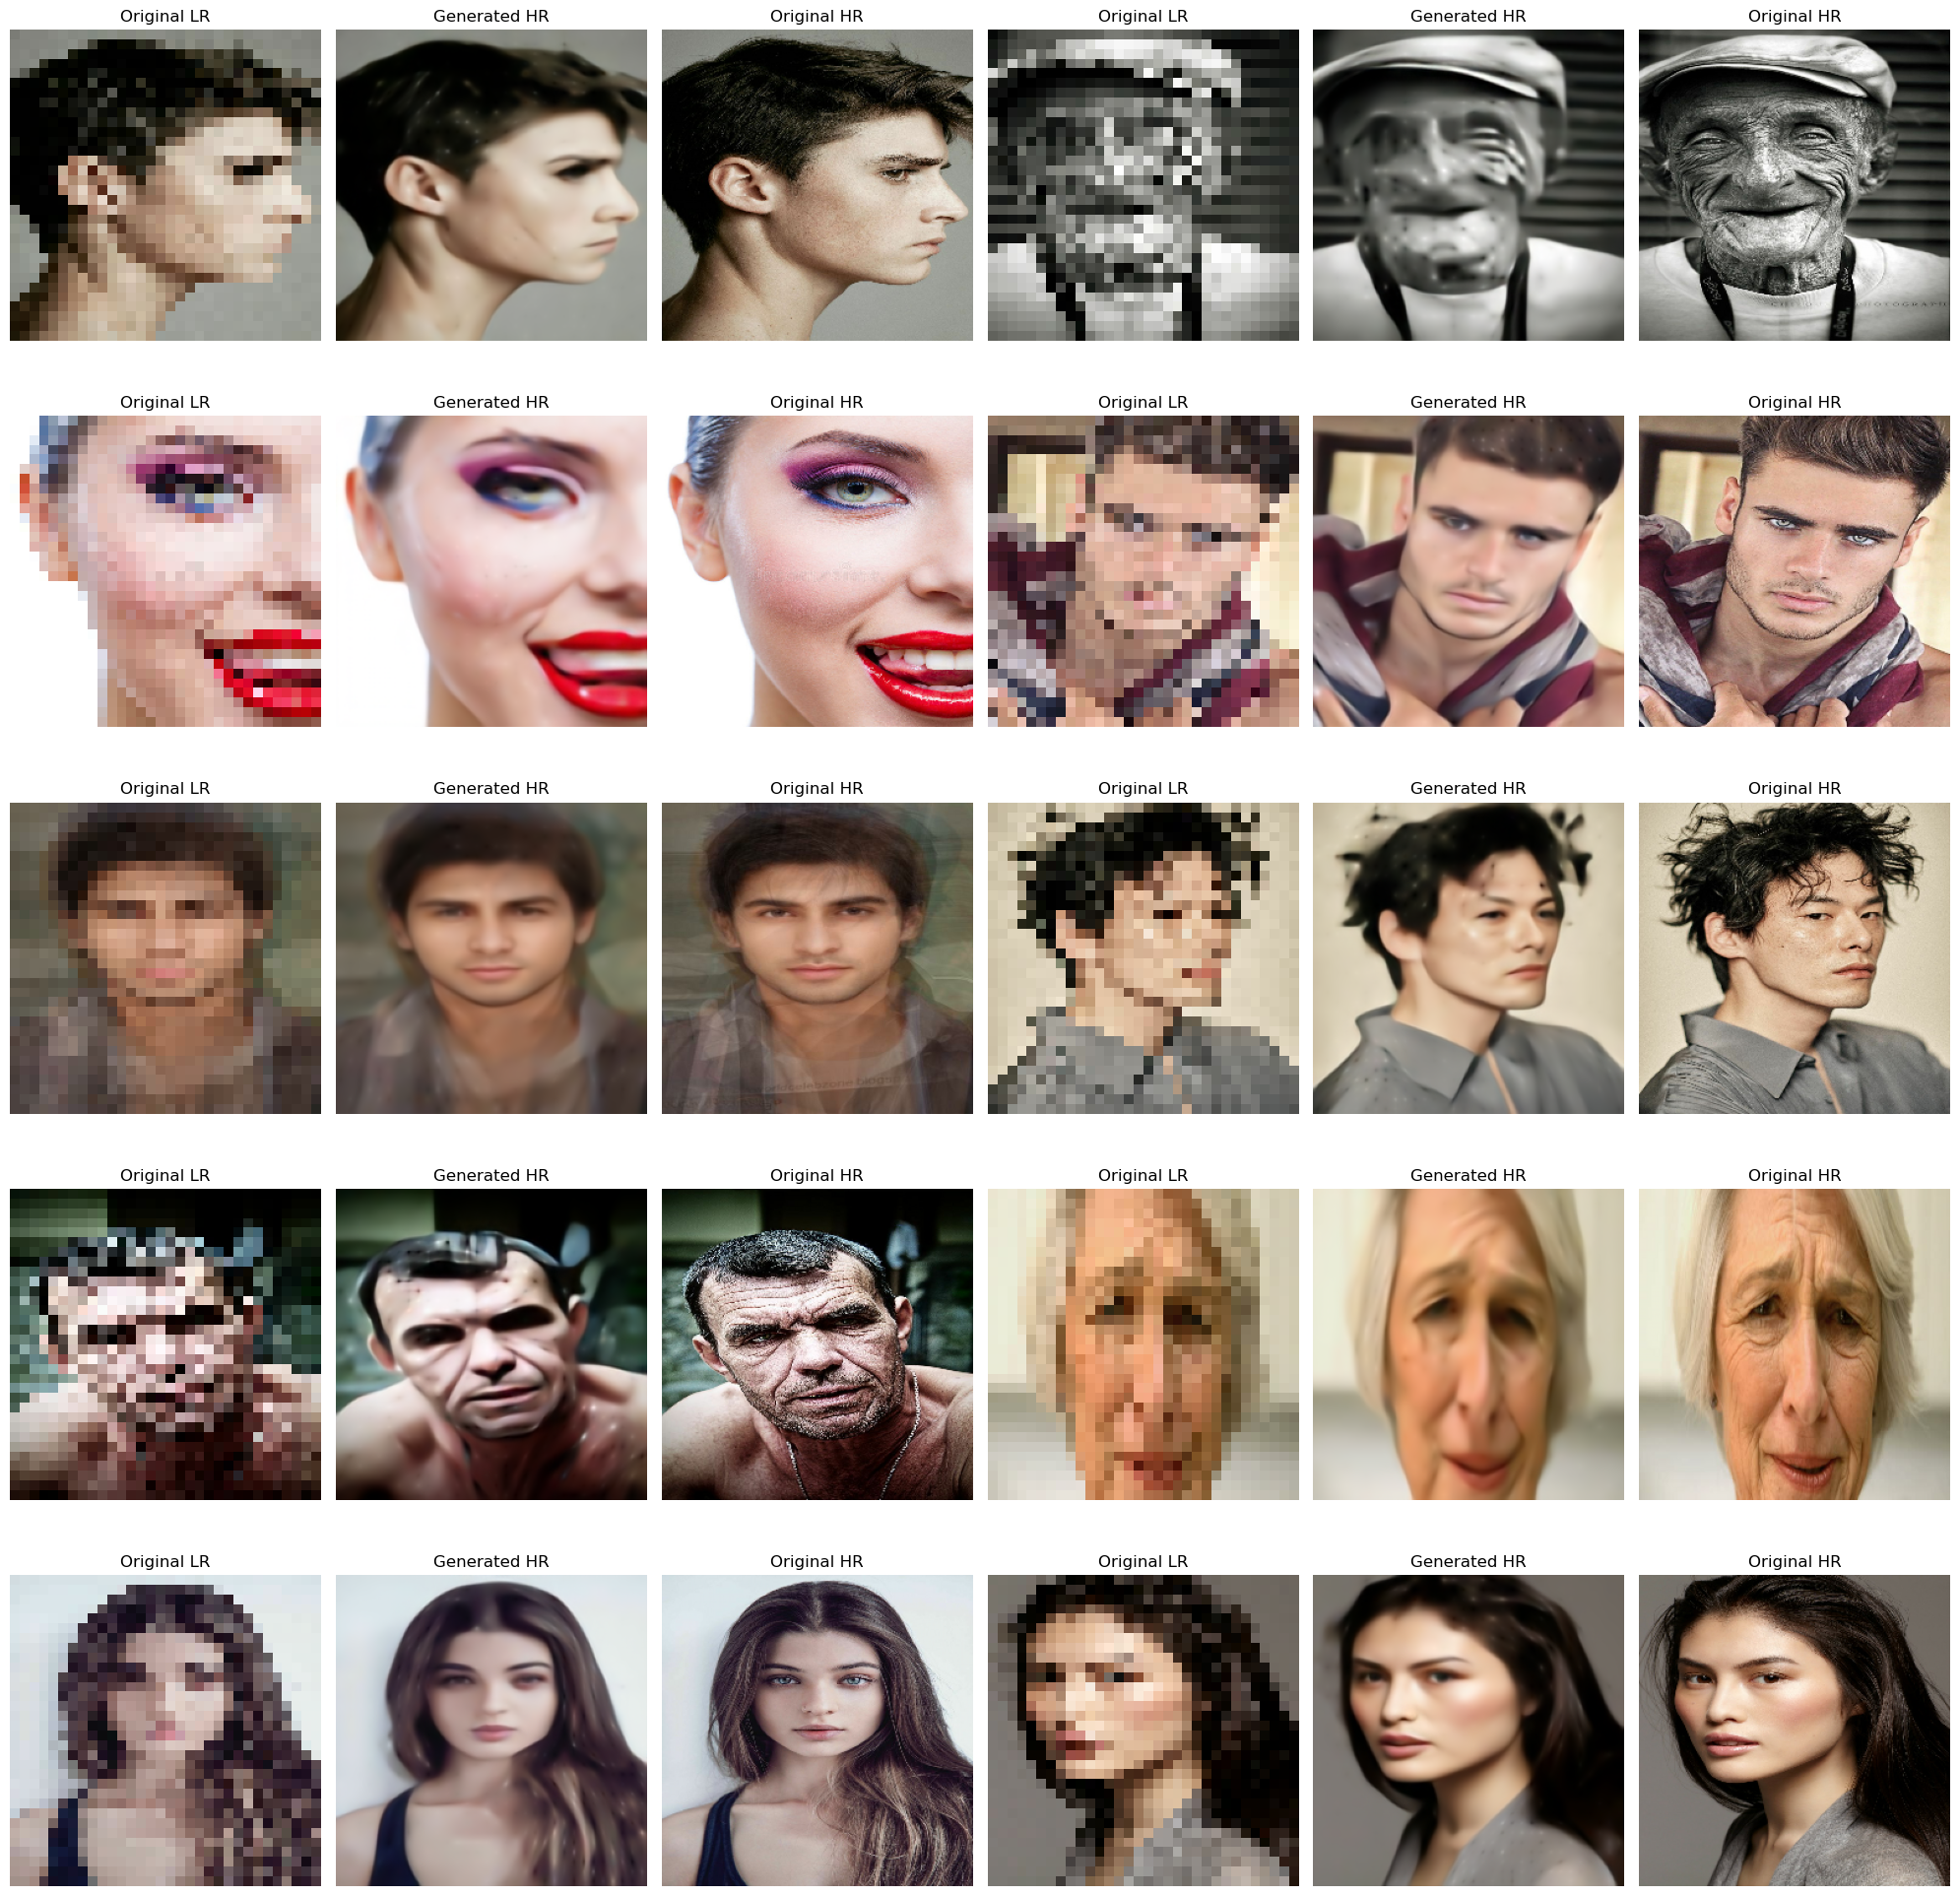

In [ ]:
res = combined_model(batch[0], training=False)

            # Clear the current figure
plt.clf()
plt.figure(figsize=(20, 20))

            # Display the first 10 images
for i in range(5):
                # Display original low-resolution image
    plt.subplot(5, 6, 6*i + 1)
    plt.imshow(batch[0][2*i, :, :, :])  # Unnormalize the image
    plt.title('Original LR')
    plt.axis('off')

                # Display generated high-resolution image
    plt.subplot(5, 6, 6*i + 2)
    plt.imshow(res[2*i, :, :, :])  # Unnormalize the image
    plt.title('Generated HR')
    plt.axis('off')

                # Display original high-resolution image
    plt.subplot(5, 6, 6*i + 3)
    plt.imshow(batch[1][2*i, :, :, :])  # Unnormalize the image
    plt.title('Original HR')
    plt.axis('off')

                # Display second set
    plt.subplot(5, 6, 6*i + 4)
    plt.imshow(batch[0][2*i + 1, :, :, :])  # Unnormalize the image
    plt.title('Original LR')
    plt.axis('off')

                # Display generated high-resolution image
    plt.subplot(5, 6, 6*i + 5)
    plt.imshow(res[2*i + 1, :, :, :])  # Unnormalize the image
    plt.title('Generated HR')
    plt.axis('off')

                # Display original high-resolution image
    plt.subplot(5, 6, 6*i + 6)
    plt.imshow(batch[1][2*i + 1, :, :, :])  # Unnormalize the image
    plt.title('Original HR')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os

def get_files_in_directory(directory_path):
    file_paths = []
    try:
        for dirpath, dirnames, filenames in os.walk(directory_path):
            for filename in filenames:
                file_paths.append(os.path.join(dirpath, filename))
        return file_paths
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Usage
directory_path = "/kaggle/input/validat-res"  # replace with your directory path
files = get_files_in_directory(directory_path)

In [ ]:
plt.figure(figsize=(7, 30))
for i, pth in enumerate(sorted(files)[:7]):
    img = tf.io.read_file(pth)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, (32, 32))
    img_transformed = combined_model(img[None])[0]

    plt.subplot(7, 2, 2*i + 1)
    plt.imshow(img)
    plt.subplot(7, 2, 2*i + 2)
    plt.imshow(img_transformed)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image
import imageio


# Input directory and output directory paths
input_dir = '/kaggle/input/validat-res/'
output_dir = '/kaggle/working/res_val'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all files in the input directory
for filename in os.listdir(input_dir):
    # Process only image files
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Open the image file
        img = tf.io.read_file(os.path.join(input_dir, filename))

        img = tf.image.decode_jpeg(img, channels=3)

    # Normalizing the images
        img = tf.cast(img, tf.float32) / 255.0

        img_transformed = combined_model(img[None])[0]

        # Ensure the processed image data is in the right format (0-255 integers)
        imageio.imsave(os.path.join(output_dir, filename), tf.cast(tf.clip_by_value(img_transformed, 0, 1)*255, tf.uint8))

In [ ]:
import shutil

# Create a zip file from my_folder
shutil.make_archive('/kaggle/working/res_val', 'zip', '/kaggle/working/res_val')

'/kaggle/working/res_val.zip'

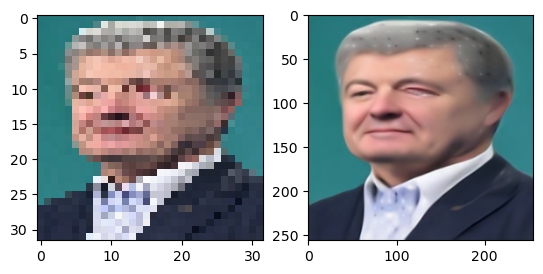

In [ ]:
img = tf.io.read_file('/kaggle/input/full-scale-im/3.jpeg')
img = tf.image.decode_jpeg(img, channels=3)
img = (tf.cast(img, tf.float32) / 255.0)[40:-40, 80:-80]
img = tf.image.resize(tf.image.resize(img, (32, 32)), (32, 32))
img_transformed = combined_model(img[None])[0]

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_transformed)

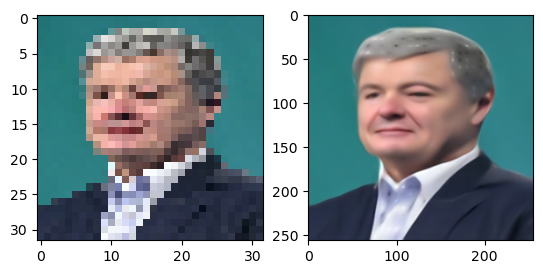

In [ ]:
img = tf.io.read_file('/kaggle/input/full-scale-im/3.jpeg')
img = tf.image.decode_jpeg(img, channels=3)
img = (tf.cast(img, tf.float32) / 255.0)
img = tf.image.resize(img, (32, 32))
img_transformed = combined_model(img[None])[0]

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_transformed)

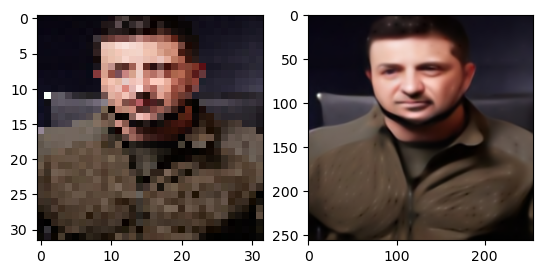

In [ ]:
img = tf.io.read_file('/kaggle/input/full-scale-im/6.jpg')
img = tf.image.decode_jpeg(img, channels=3)
img = (tf.cast(img, tf.float32) / 255.0)[40:-40, 80:-80]
img = tf.image.resize(tf.image.resize(img, (32, 32), method='nearest'), (32, 32), method='nearest')
img_transformed = combined_model(img[None])[0]

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_transformed)

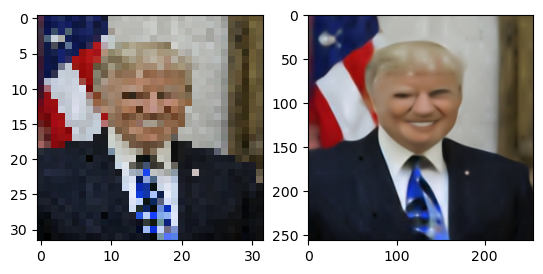

In [ ]:
img = tf.io.read_file('/kaggle/input/dddddd/Donald_Trump_official_portrait.jpg')
img = tf.image.decode_jpeg(img, channels=3)
img = (tf.cast(img, tf.float32) / 255.0)#[200:-200,200:-200]
img = tf.image.resize(tf.image.resize(img, (32, 32)), (32, 32))
img_transformed = combined_model(img[None])[0]

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_transformed)

In [ ]:
img = tf.io.read_file('/kaggle/input/myself2/K66mzNHnZD8Tlt527T7UGHmdNIAb60JGZ9W1UhIu.jpg')
img = tf.image.decode_jpeg(img, channels=3)
img = (tf.cast(img, tf.float32) / 255.0)#[200:-200,200:-200]
img = tf.image.resize(tf.image.resize(img, (32, 32)), (32, 32))
img_transformed = combined_model(img[None])[0]

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_transformed)